In [1]:
# ========================
# Step 1: Imports
# ========================

import os
import gzip
import json
import dask
import awkward as ak
import numpy as np
import sys
import importlib

from coffea.nanoevents import NanoAODSchema
from coffea.dataset_tools import apply_to_fileset, max_chunks, max_files
from dask.distributed import Client
from pathlib import Path

current_dir = Path.cwd()
#print(current_dir)
#processors_dir = current_dir.parent / "processors"
processors_dir = current_dir # used to keep processors separate but that was bad
path_to_run_on = current_dir.parent
path_to_master_json = current_dir.parent.parent / "src" / "dataset_tools"

sys.path.append(str(processors_dir))

processor_name = "AN_plot_processor" # without .py
run_on_name = "run_on_custom.json"

processor_module = importlib.import_module(processor_name)
Processor = processor_module.Processor

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
import json

with open(path_to_master_json / "datasets_master.json") as file:
    datasets = json.load(file)

with open(path_to_run_on / run_on_name) as file:
    run_on = json.load(file)
#print(run_on)

In [3]:
import cloudpickle

results = {}

for AOD_type in run_on.keys():
    for year in run_on[AOD_type]:
        for sample_name in run_on[AOD_type][year]:
            #print(run_on[AOD_type][year][sample_name].keys())
            entry = run_on[AOD_type][year][sample_name]
            print(f"sample in json: {sample_name}")
            

            if entry['run']:

                preprocessed_file_path = (
                    path_to_master_json / 
                    datasets[AOD_type][year][sample_name]['preprocessed_file']
                )

                with gzip.open(preprocessed_file_path, "rt") as f:
                    preprocessed_file = json.load(f)

                num_files = entry['num_files']
                num_chunks = entry['num_chunks']

                client = Client("tls://localhost:8786")

                if entry["use_client"]:
                    print("using client")
                else:
                    client.close()
                    
                
                if entry['reduced_computation']:
                    test_files  = max_files(preprocessed_file, num_files)
                    test_chunks = max_chunks(test_files, num_chunks)
                
                    tg, rep = apply_to_fileset(
                        data_manipulation=Processor(),
                        fileset=test_chunks,
                        schemaclass=NanoAODSchema,
                        uproot_options={"allow_read_errors_with_report": (OSError, KeyError)},
                    )
                else:
                    tg, rep = apply_to_fileset(
                        data_manipulation=Processor(),
                        fileset=preprocessed_file,
                        schemaclass=NanoAODSchema,
                        uproot_options={"allow_read_errors_with_report": (OSError, KeyError)},
                    )

                #client.scheduler_info()
                print("sample loaded, running, hold please.........")
                result, report = dask.compute(tg, rep)

                pikl_result_path = Path('pikls') / processor_name
                pikl_result_path.mkdir(parents=True, exist_ok=True)
                with open(pikl_result_path / f"{sample_name}.pkl", "wb") as f:
                    cloudpickle.dump(result, f)
                
                #ak.to_json(report[], f"pikls/{sample_name}_{processor_name}_report.json", num_indent_spaces=2)
                print(f"done with {sample_name}")
            else:
                print('skipping')
                continue
if client.status == 'running':
    client.close()

sample in json: SlepSnu_MN1-260_MN2-280_MC1-270
skipping
sample in json: SlepSnu_MN1-220_MN2-260_MC1-240
skipping
sample in json: SlepSnu_MN1-270_MN2-280_MC1-275
sample loaded, running, hold please.........
done with SlepSnu_MN1-270_MN2-280_MC1-275
sample in json: TTto2L2Nu
sample loaded, running, hold please.........
done with TTto2L2Nu
sample in json: WZ
skipping
sample in json: WW
skipping
sample in json: DY_to2L_2J
skipping
sample in json: DY_to2L_4J
skipping
sample in json: Prompt_JPsi_toEE_pth10toInf
skipping


In [4]:
r = result[list(result)[0]]

In [5]:
r

{'total_entries': 5658000,
 'ele_dict': {'pt_eta_hist': Hist(
    Variable([2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
    Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'),
    IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
    IntCategory([-1, 1, 2, 3], name='qual_tag'),
    storage=Double()) # Sum: 8265706.0 (8974889.0 with flow),
  'pt_AN_hist_v1': Hist(
    Regular(40, 0, 100, name='pt'),
    IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
    IntCategory([-1, 1, 2, 3], name='qual_tag'),
    storage=Double()) # Sum: 8555760.0 (8974889.0 with flow),
  'pt_AN_hist_v2': Hist(
    Variable(array([  2. ,   3. ,   4. ,   5. ,   7. ,  10. ,  12.5,  15. ,  17.5,
          20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,
          42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,
          65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,
          87.5,  90. ,  92.5,  95. ,  97.5, 100. ]), name='pt'),
    IntCategory([-10, 10, 11, 12, 

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep
mplhep.style.use(mplhep.style.CMS)
plt.figure()
mplhep.style.use(mplhep.style.CMS)

<Figure size 1000x1000 with 0 Axes>

(0.0, 10.0)

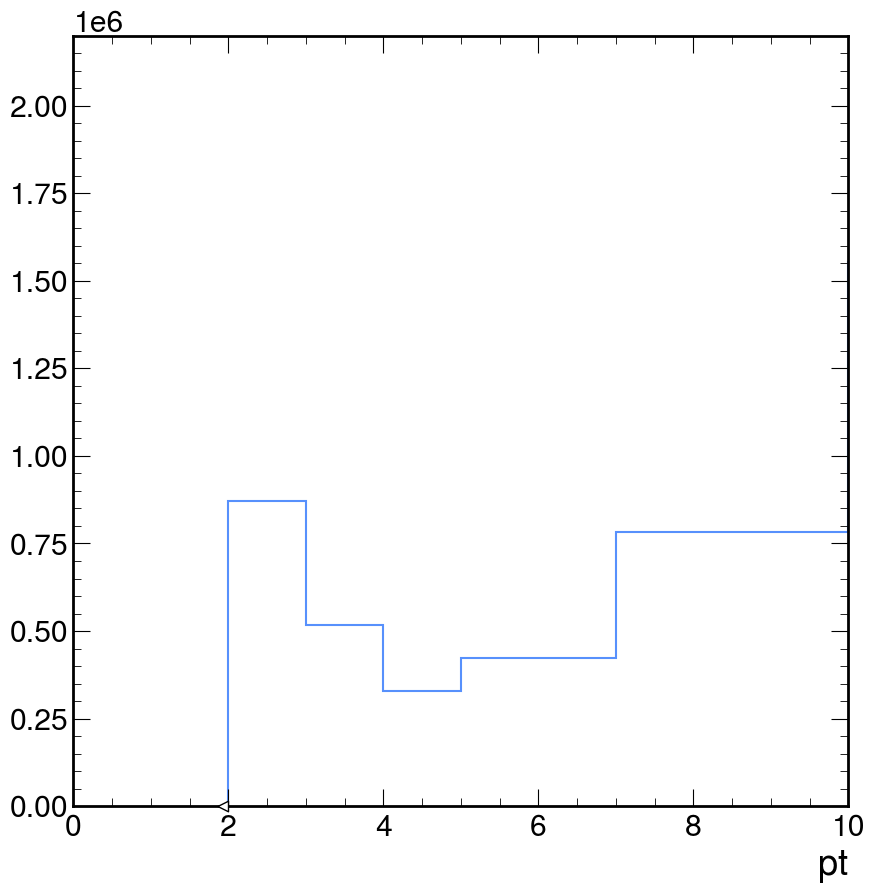

In [7]:
r['ele_dict']['pt_eta_hist'].project('pt').plot()
plt.xlim(0,10)